## Prediction Tendency (Example)

We manipulated the entropy of a sequence of events (4 different pure tones; f1: 440 Hz, f2: 587 Hz, f3: 782 Hz, and f4: 1,043 Hz) using markov chains. In one condition events were "ordered" i.e. the transitional probability from f1 → f2, f2 → f3, f3 → f4 and f4 → f1 was 75% (self repetitions had a probability of 25%; e.g. f1 → f1). In another condition events were "random" i.e. the probability of forward transitions and self repetitions was 25%. 

We trained a classifier on the forward transitions of the "ordered" condition in a time-resolved manner and tested on the self-repetitions of the "random" and "ordered" conditions. This resulted in classifier decision values (dvals) for every possible sound frequency (d1, d2, d3, and d4) of all test trials (t) which were then transformed into corresponding transitions with respect to the preceding sound (t − 1) (e.g. d1(t) | f1(t − 1) “dval for f1 at trial t given that f1 was presented at trial t − 1” → repetition, d2(t) | f1(t − 1) → forward,...).

We quantify prediction tendency as the classifiers pre-stimulus decision in favor of a forward transition in an ordered compared with a random context. For more info [see](https://academic.oup.com/cercor/article/33/11/6608/6975346?login=true.)


In [7]:
#imports
from pymatreader import read_mat
import numpy as np
from os.path import join

from mne.decoding import (UnsupervisedSpatialFilter, SlidingEstimator)

from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

from pred_tend import compute_dvals, get_pred_tend
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')
sns.set_context('poster')

rng = np.random.RandomState(420)

In [8]:
def load_data(cur_path):

    cur_data = read_mat(cur_path)['data']

    or_d, rd_d, or_l, rd_l = [], [], [], []

    for cur_block in cur_data:

        ordered_mask = cur_block['trialinfo'][:,0] == 1
        random_mask = cur_block['trialinfo'][:,0] == 2

        or_d.append(np.array(cur_block['trial'])[ordered_mask,::])
        rd_d.append(np.array(cur_block['trial'])[random_mask,::])
        or_l.append(np.array(cur_block['trialinfo'])[ordered_mask,1])
        rd_l.append(np.array(cur_block['trialinfo'])[random_mask,1])

        
    return np.concatenate(or_d), np.concatenate(rd_d), np.concatenate(or_l), np.concatenate(rd_l)


INDIR = '/mnt/obob/staff/fschmidt/neurogram/data/markov4decoding'
or_d_q, rd_d_q, or_l_q, rd_l_q = load_data(join(INDIR, '19891222gbhl.mat'))

# %%
X_or, y_or = or_d_q, or_l_q
X_rd, y_rd = rd_d_q, rd_l_q

In [23]:
clf = make_pipeline(UnsupervisedSpatialFilter(PCA(100),
                                              average=False),
                    SlidingEstimator(LinearDiscriminantAnalysis(solver='lsqr',
                                                                shrinkage='auto',
                                                                )))


dvals_or, dvals_rd = compute_dvals(clf, X_or, y_or, X_rd, y_rd)
time = np.arange(-.416, .785, .01)
#%% get prediction tendency
df = pd.DataFrame({'ordered': dvals_or,
                   'random': dvals_rd,
                   'time': time}).melt(id_vars='time', var_name='condition', value_name='dvals')

  0%|          | Fitting SlidingEstimator : 0/121 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/121 [00:00<?,       ?it/s]

  0%|          | Transforming SlidingEstimator : 0/121 [00:00<?,       ?it/s]

Text(0, 0.5, 'Decision Value \n Repetition <--> Forward    ')

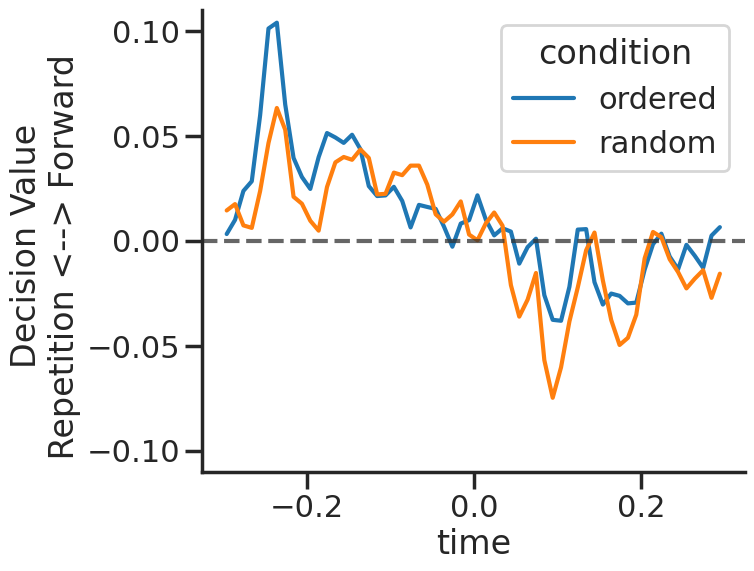

In [24]:

f, ax = plt.subplots(figsize=(7, 6))
sns.lineplot(df.query('time > -.3').query('time < 0.3'), x='time', y='dvals', hue='condition', ax=ax)
sns.despine()
plt.axhline(y=0, color='#333333', linestyle='--', alpha=0.75)
ax.set_ylim(-.11, .11)
ax.set_ylabel('Decision Value \n Repetition <--> Forward    ')

In [25]:
time_mask = np.logical_and(time > -.3, time < 0)
pred_tend = get_pred_tend(dvals_or, dvals_rd, time_mask)

print(f'The Prediction Tendency of the subject is {pred_tend}')

The Prediction Tendency of the subject is 0.19190261224184169
